In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import seaborn as seabornInstance

import matplotlib.pyplot as plt
from scipy.stats import norm
import datetime

import plotly.offline as py
py.init_notebook_mode()
%matplotlib inline
plt.style.use('fivethirtyeight') # For plots

In [54]:
#Prophet
from fbprophet import Prophet
from fbprophet.plot import plot_plotly
from fbprophet.plot import add_changepoints_to_plot

#skleran
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn import tree
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.metrics import r2_score

## Timeseries with Prophet - Rainfall

In [3]:
df_read= pd.read_csv('df_clean.csv')

In [4]:
#create timeseries features to show how trends are impacted by day of week, quarter, year, time of year.
ragp = df_read.copy()
ragp['datetime'] = pd.to_datetime(ragp['datetime'])
ragp = ragp[['datetime','City','Rainfall(in)']]
ragp.set_index('datetime', inplace=True)
ragp.drop('City', axis=1, inplace=True)
ragp

Rainfall(in)
datetime                
2010-01-01          0.00
2010-01-02          0.00
2010-01-03          0.00
2010-01-04          0.00
2010-01-05          0.00
...                  ...
2019-12-27          0.00
2019-12-28          0.32
2019-12-29          0.07
2019-12-30          0.00
2019-12-31          0.00

[18243 rows x 1 columns]

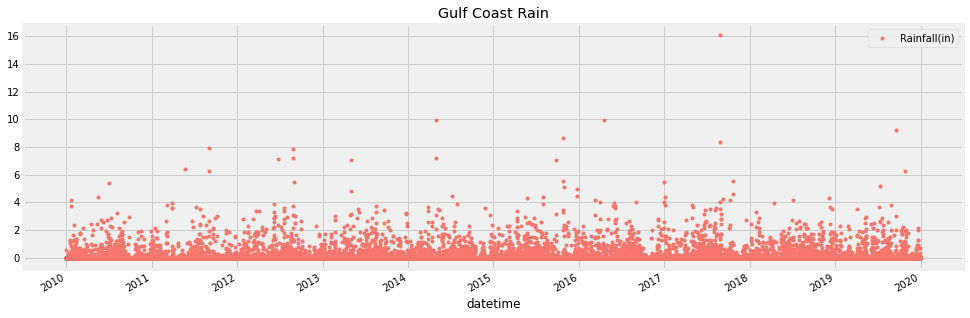

In [5]:
# Color pallete for plotting
color_pal = ["#F8766D", "#D39200", "#93AA00",
             "#00BA38", "#00C19F", "#00B9E3",
             "#619CFF", "#DB72FB"]
ragp.plot(style='.', figsize=(15,5), color=color_pal[0], title='Gulf Coast Rain')
plt.show()

In [6]:
#create time series features to see how the trends are impacted by day, week, quarter, month, year
def create_features(df, label=None):
    """
    Creates time series features from datetime index.
    """
    df = df.copy()
    df['date'] = df.index
    df['day'] = df['date'].apply(pd.to_datetime).dt.dayofweek
    df['quarter'] = df['date'].apply(pd.to_datetime).dt.quarter
    df['month'] = df['date'].apply(pd.to_datetime).dt.month
    df['year'] = df['date'].apply(pd.to_datetime).dt.year
    df['dayYear'] = df['date'].apply(pd.to_datetime).dt.dayofyear
    df['dayMonth'] = df['date'].apply(pd.to_datetime).dt.day
    df['weekYear'] = df['date'].apply(pd.to_datetime).dt.weekofyear
    
    X = df[['day','quarter','month','year',
           'dayYear','dayMonth','weekYear']]
    if label:
        y = df[label]
        return X, y
    return X

X, y = create_features(ragp, label='Rainfall(in)')

features_and_target = pd.concat([X, y], axis=1)

features_and_target.head()

day  quarter  month  year  dayYear  dayMonth  weekYear  \
datetime                                                             
2010-01-01    4        1      1  2010        1         1        53   
2010-01-02    5        1      1  2010        2         2        53   
2010-01-03    6        1      1  2010        3         3        53   
2010-01-04    0        1      1  2010        4         4         1   
2010-01-05    1        1      1  2010        5         5         1   

            Rainfall(in)  
datetime                  
2010-01-01           0.0  
2010-01-02           0.0  
2010-01-03           0.0  
2010-01-04           0.0  
2010-01-05           0.0

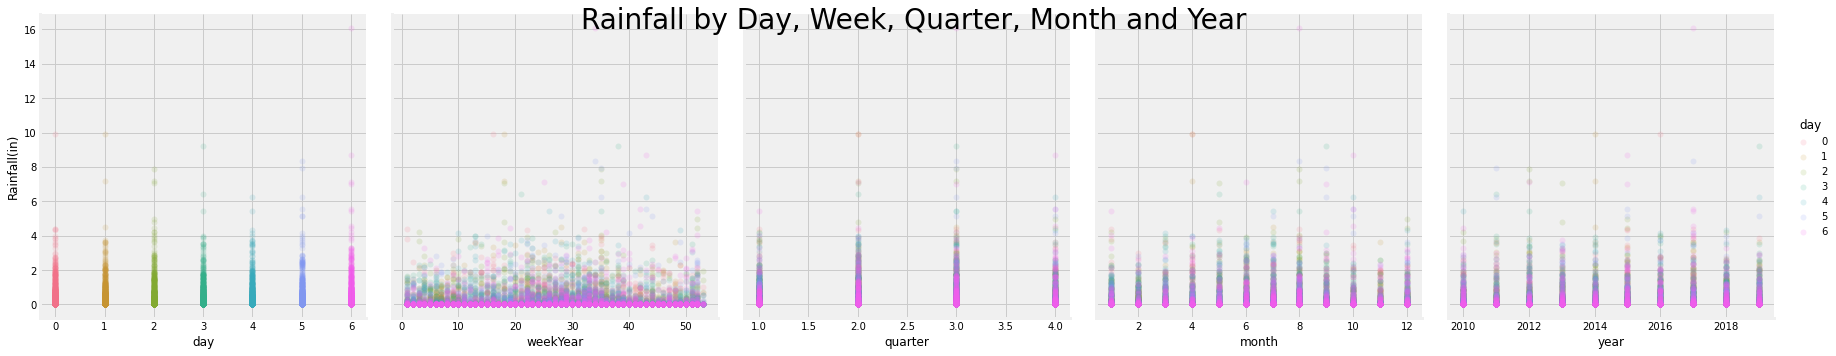

In [7]:
#plotting features to see trends
#Rainfall has strong monthly properties
plt.rcParams['figure.figsize']=(30,15)
sns.pairplot(features_and_target.dropna(),
             hue='day',
             x_vars=['day', 'weekYear','quarter', 'month',
                     'year'],
             y_vars='Rainfall(in)',
             height=5,
             plot_kws={'alpha':0.15, 'linewidth':0}
            )
plt.suptitle('Rainfall by Day, Week, Quarter, Month and Year', fontsize=28)
plt.show()

### Create the input data for Prophet

We'll be using our dataset that we already cleaning in our data wrangling section. We still need to manipulate it a bit to work with Prophet.

In [8]:
#prepare our dataset for Prophet timeseries
df = df_read.copy()

#Convert string datetime into readable datetime object
df['datetime'] = pd.to_datetime(df['datetime'])

#create dataframe with columns that we'll be using
df = df[['datetime','Dewpoint_temp(°F)','Humidity(%)','Sealevel_pressure(Hg)','Max_temp(°F)','Min_temp(°F)',
           'Average_temp(°F)', 'Wind_speed(mph)','Rainfall(in)']]

#set index to datetime
df.set_index('datetime', inplace=True)

print(df.shape)

(18243, 8)


In [9]:
#remove outliers about 5.5 inches of rain 
df= df[df['Rainfall(in)'] < 5.5]
df.shape

(18225, 8)

In [10]:
#create input features and target variable
#drop feature
X= df.drop('Rainfall(in)', axis=1)

#include features
y= df['Rainfall(in)']

In [11]:
#importances of our values in correlation to their impact on rainfall
importances= X.apply(lambda x: x.corr(y))
indices= np.argsort(importances)
print(importances[indices])

Sealevel_pressure(Hg)   -0.194383
Max_temp(°F)             0.007984
Average_temp(°F)         0.064095
Min_temp(°F)             0.109440
Dewpoint_temp(°F)        0.159427
Wind_speed(mph)          0.326622
Humidity(%)              0.331100
dtype: float64


***As we can see, wind speed and humidity have the biggest correlation with rainfall.***

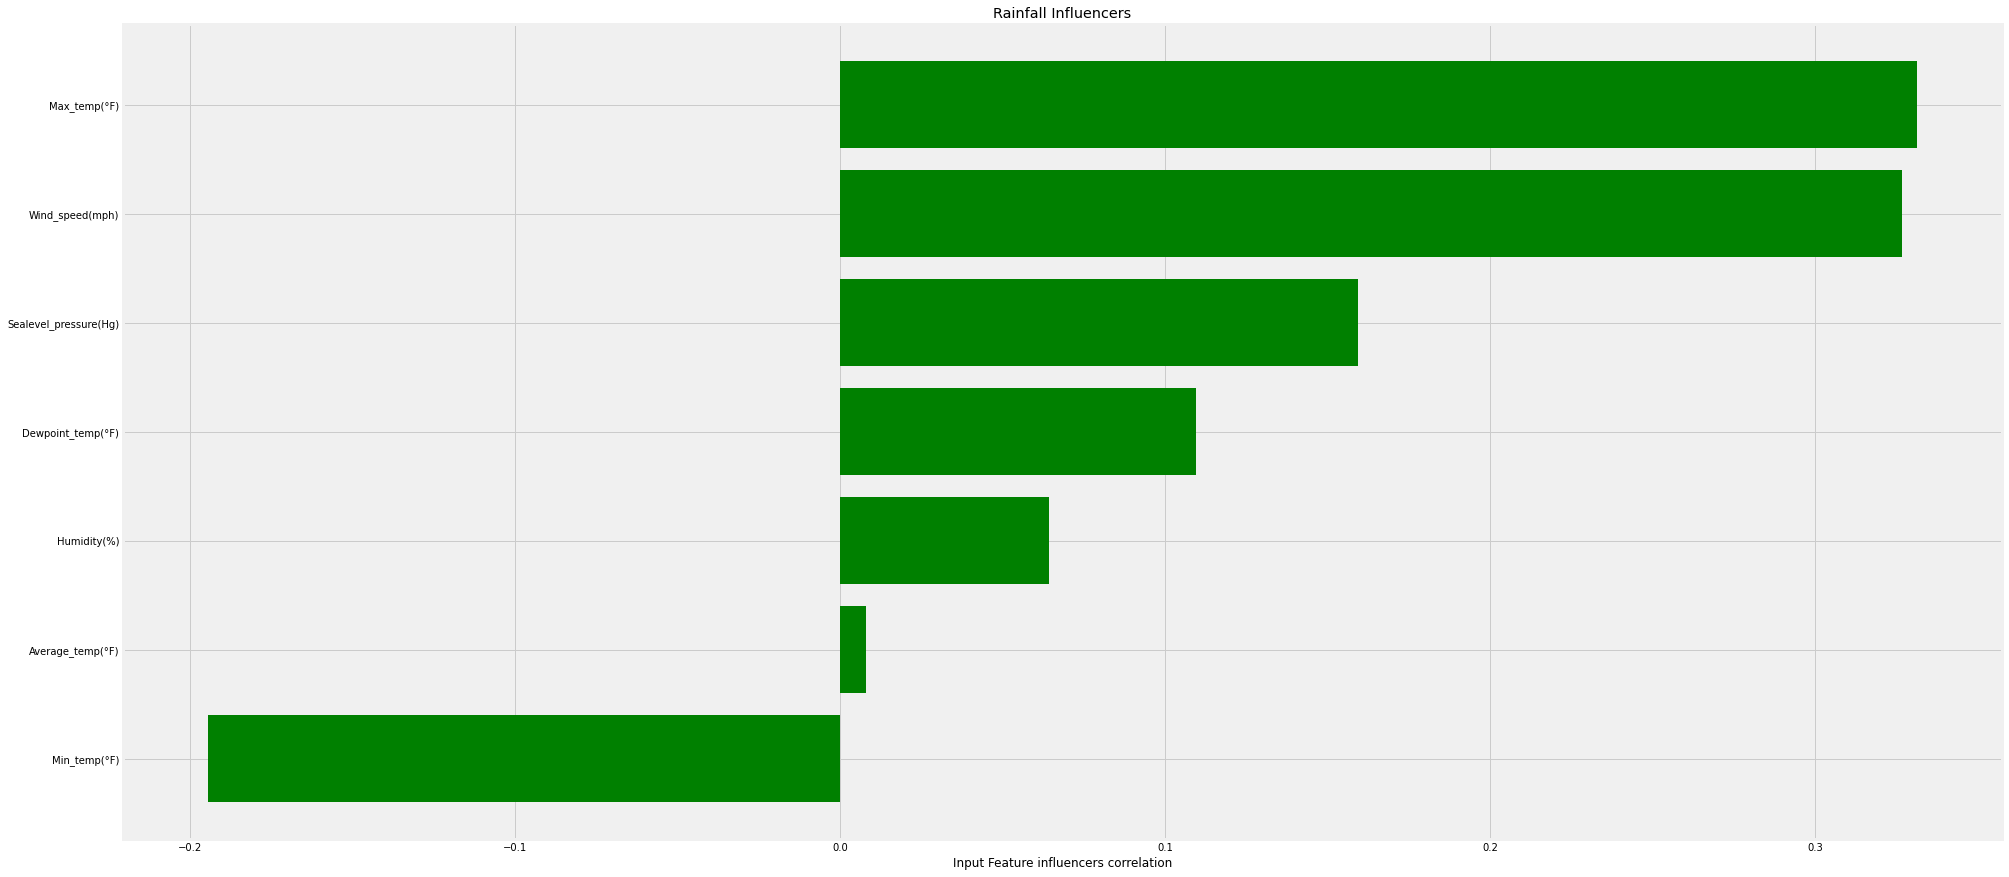

In [12]:
names=['Sealevel_pressure(Hg)', 'Max_temp(°F)', 'Min_temp(°F)', 'Average_temp(°F)',
       'Dewpoint_temp(°F)', 'Humidity(%)', 'Wind_speed(mph)', 'type']
plt.title('Rainfall Influencers')
plt.barh(range(len(indices)), importances[indices], color='g', align='center')
plt.yticks(range(len(indices)), [names[i] for i in indices])
plt.xlabel('Input Feature influencers correlation')
plt.show()

In [13]:
df1 = df_read.copy()
df1= df1[df1['Rainfall(in)'] < 5.5]

#create input features and target variable from dataset with datetime
#drop feature
X= df1.drop('Rainfall(in)', axis=1)

#include features
y= df1['Rainfall(in)']

In [14]:
#create dataframe with ds(datestamp) and y(predicted numeric column)
train_dataset= pd.DataFrame()
train_dataset['ds'] = pd.to_datetime(X["datetime"])
train_dataset['y']=y
train_dataset.head(2)

ds    y
0 2010-01-01  0.0
1 2010-01-02  0.0

In [15]:
#create and fit model with default values
# set the uncertainty interval to 95% (the Prophet default is 80%)
prophet_basic = Prophet(interval_width=0.95)

#fit model
prophet_basic.fit(train_dataset)

INFO:numexpr.utils:NumExpr defaulting to 4 threads.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [16]:
#predict values for the future
future= prophet_basic.make_future_dataframe(periods=731)
future.tail(5)

ds
18951 2021-12-27
18952 2021-12-28
18953 2021-12-29
18954 2021-12-30
18955 2021-12-31

***We set our future at 2 years(730 days) past our original dataset. Our future contains 18973 and will predict into the future (2021-12-31)***

In [17]:
#create forecast of future
forecast=prophet_basic.predict(future)

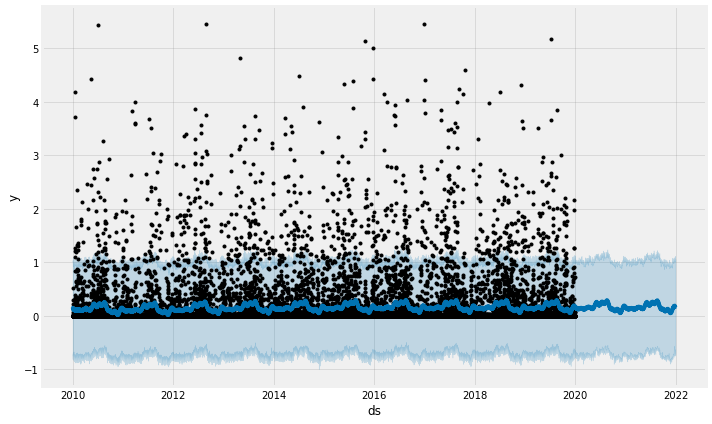

In [18]:
#plot predicted data
fig1 =prophet_basic.plot(forecast)

***The blue lines represent the forecasted values and the uncertainty intervals of the forecasts are the blue shaded regions.***

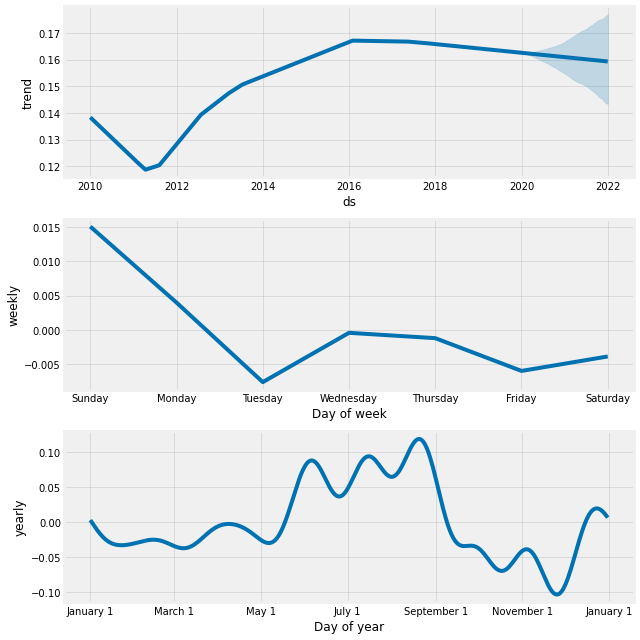

In [19]:
#plot the forecasted components
fig1 = prophet_basic.plot_components(forecast)

***The first plot shows that the monthly volume of rainfall dropped in 2011 but steadily increased until 2016 when it started to decrease slightly each year.***

***The second plot shows a mostly decrease in weekly trends. Day of the week isn't commonly a factor in weather though.***

***Our final plot is interesting because traditionally weather is affected by seasonal habits. As we can see in our plot, the warmer months of May-September were higher than the rest of the year but there were dips within those months.***

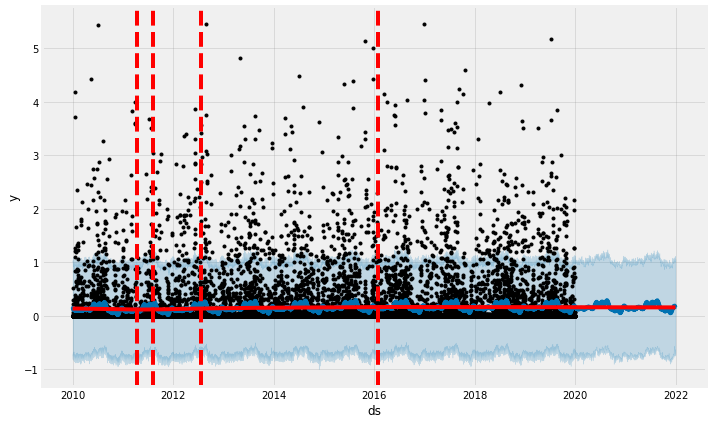

In [20]:
#Prophet detects changepoints by first specifying a large number of potential ChangePoints at which the rate is allowed to change
fig = prophet_basic.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), prophet_basic, forecast)

In [21]:
#view the dates where the ChangePoints occurred
prophet_basic.changepoints

583     2010-04-27
1166    2010-08-22
1749    2010-12-16
2333    2011-04-12
2916    2011-08-07
3499    2011-12-02
4082    2012-03-29
4665    2012-07-24
5248    2012-11-18
5832    2013-03-14
6415    2013-07-09
6998    2013-11-03
7581    2014-03-01
8164    2014-06-26
8747    2014-10-20
9331    2015-02-15
9914    2015-06-12
10497   2015-10-06
11080   2016-01-31
11663   2016-05-27
12246   2016-09-21
12830   2017-01-16
13413   2017-05-12
13996   2017-09-06
14579   2018-01-01
Name: ds, dtype: datetime64[ns]

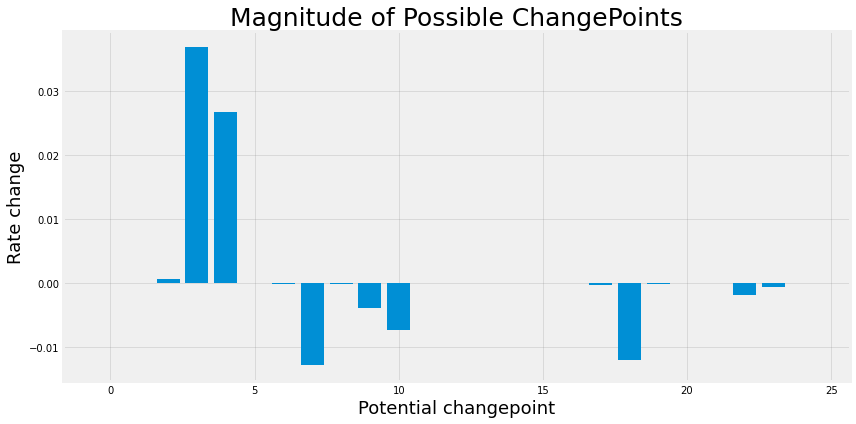

In [22]:
#look at the magnitudes of these possible changepoints
deltas = prophet_basic.params['delta'].mean(0)
fig = plt.figure(figsize=(12,6),facecolor='w')
ax = fig.add_subplot(111)
ax.bar(range(len(deltas)), deltas)
ax.grid(True, which='major', c='gray', ls='-', lw=1, alpha=0.2)
ax.set_title('Magnitude of Possible ChangePoints', fontsize=25)
ax.set_ylabel('Rate change', fontsize=18)
ax.set_xlabel('Potential changepoint', fontsize=18)
fig.tight_layout()

### Ajusting Trend

By default the scale is set to 0.05 so we'll adjust the trend to be more flexible by increasing the value and then by decreasing the value.


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


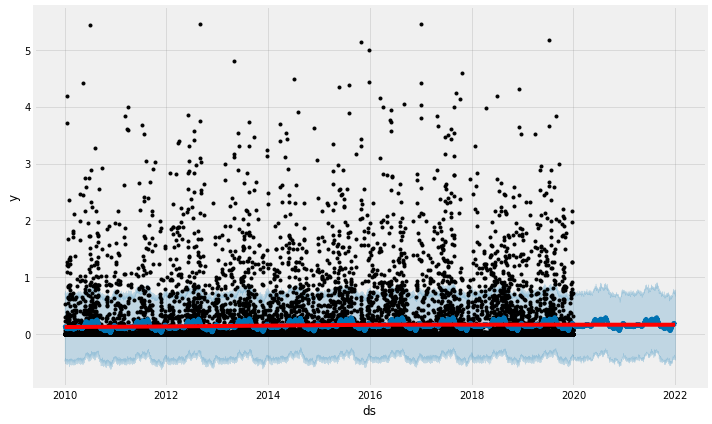

In [23]:
#decrease the ChangePoint prior scale
pro_change= Prophet(n_changepoints=20, yearly_seasonality=True, changepoint_prior_scale=0.02)
forecast = pro_change.fit(train_dataset).predict(future)
fig= pro_change.plot(forecast);
a = add_changepoints_to_plot(fig.gca(), pro_change, forecast)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


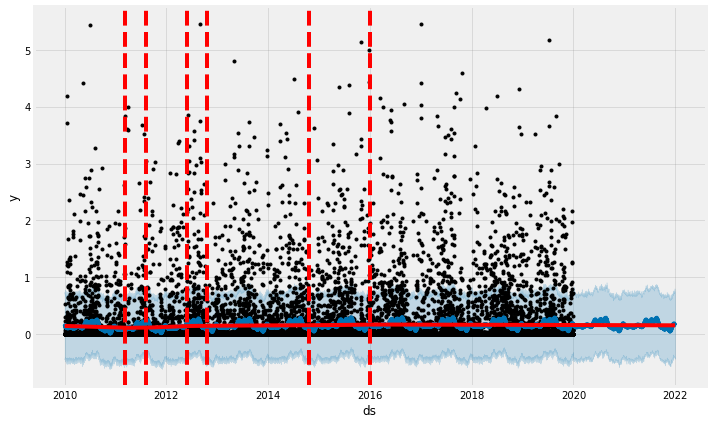

In [24]:
#increase the ChangePoint prior scale
pro_change= Prophet(n_changepoints=20, yearly_seasonality=True, changepoint_prior_scale=0.08)
forecast = pro_change.fit(train_dataset).predict(future)
fig= pro_change.plot(forecast);
a = add_changepoints_to_plot(fig.gca(), pro_change, forecast)

In [25]:
#view the dates where the ChangePoints occurred
pro_change.changepoints

729     2010-05-26
1458    2010-10-19
2187    2011-03-14
2916    2011-08-07
3645    2012-01-01
4374    2012-05-26
5103    2012-10-20
5832    2013-03-14
6561    2013-08-08
7290    2014-01-01
8018    2014-05-27
8747    2014-10-20
9476    2015-03-16
10205   2015-08-09
10934   2016-01-02
11663   2016-05-27
12392   2016-10-20
13121   2017-03-15
13850   2017-08-08
14579   2018-01-01
Name: ds, dtype: datetime64[ns]

***Our graphs did a good job of predicting a base amount of rainfall for the next 2 years. We can fine tune it a bit more to get more precise blue lines and blue shaded area.***

## Simple Linear Regression

In [26]:
#create our dataframe for Linear Regression starting with our cleaned dataset
df_lr = df_read.copy()

#we know that our outliers are mainly found above 6 inches of rain so we'll remove them from our dataset
df_lr= df_lr[df_lr['Rainfall(in)'] < 6]

In [27]:
df_lr.describe()

Dewpoint_temp(°F)   Humidity(%)  Sealevel_pressure(Hg)  Max_temp(°F)  \
count       18227.000000  18227.000000           18227.000000  18227.000000   
mean           60.490635     73.613779              30.049377     79.980743   
std            13.937013     11.390546               0.140199     12.203567   
min             4.708333     21.000000              29.440000     31.000000   
25%            52.000000     67.000000              29.960000     72.000000   
50%            64.422222     75.000000              30.036250     82.000000   
75%            72.000000     82.000000              30.130000     90.000000   
max            80.000000    100.000000              30.695417    109.000000   

       Min_temp(°F)  Average_temp(°F)  Wind_speed(mph)  Rainfall(in)  
count  18227.000000      18227.000000     18227.000000  18227.000000  
mean      61.399517         70.941022        22.751193      0.152772  
std       14.034267         12.751247         6.916459      0.459829  
min       16.000000         26.000000         0.000000      0.000000  
25%       51.000000         62.000000        18.000000      0.000000  
50%       65.000000         74.000000        22.000000      0.000000  
75%       74.000000         82.000000        26.000000      0.030000  
max       85.000000         95.000000       120.000000      5.580000

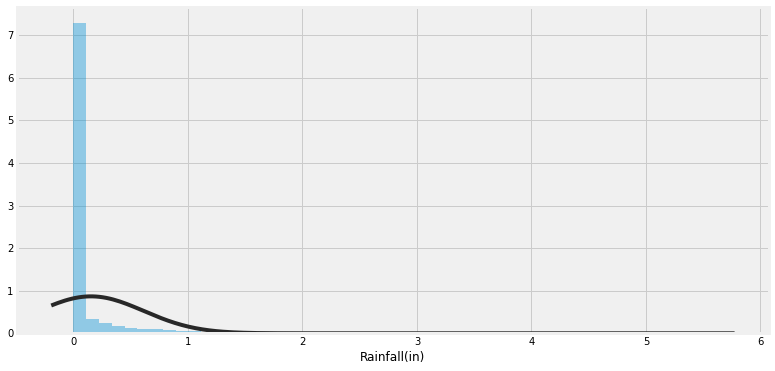

In [28]:
#plot our Rainfall value
plt.figure(figsize=(12,6))
plt.tight_layout()
seabornInstance.distplot(df_lr['Rainfall(in)'],fit=norm, kde=False)

***We can see that a majority of our days consisted of zero rainfall with amounts under 1" having a strong showing as well. Average looks to be around 0.01-0.02 inches***

In [29]:
#divide dataframe into independent variables(X) and dependent variables(y)
X = df_lr['Humidity(%)'].values.reshape(-1,1)
y = df_lr['Rainfall(in)'].values.reshape(-1,1)

In [30]:
#split 70% of our dataset into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [31]:
#train our algorithm
regressor = LinearRegression()  
regressor.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [32]:
#To retrieve the intercept:
print(regressor.intercept_)

#For retrieving the slope:
print(regressor.coef_)

[-0.82742469]
[[0.01329894]]


***We can see that for every one unit of change in Dewpoint temps, there is a minimal change in Rainfall.***

In [33]:
#make predictions with our test data
y_pred = regressor.predict(X_test)

In [34]:
#compare the actual output values with the predicted values
dl = pd.DataFrame({'Actual': y_test.flatten(), 'Predicted': y_pred.flatten()})
dl

Actual  Predicted
0       0.00  -0.029489
1       0.00   0.063604
2       0.01   0.249789
3       0.00   0.276387
4       0.00  -0.002891
...      ...        ...
5464    0.00   0.130099
5465    0.00   0.156697
5466    1.00   0.236490
5467    0.00   0.130099
5468    0.00   0.130099

[5469 rows x 2 columns]

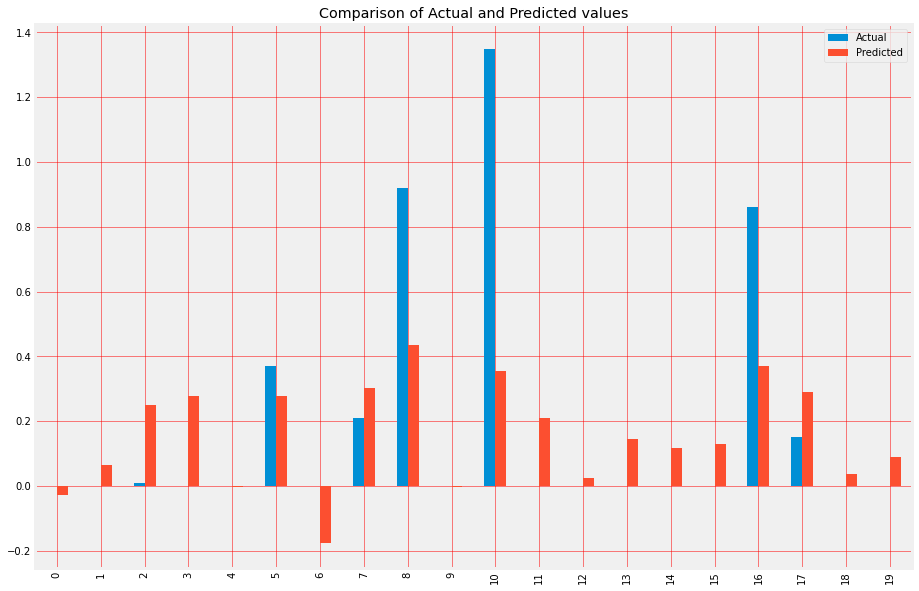

In [35]:
#we'll take a look at the 1st 20 records
dl1 = dl.head(20)
dl1.plot(kind='bar',figsize=(14,10))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='red')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.title('Comparison of Actual and Predicted values')
plt.show()

***We can see that our predicted precentages aren't close to our actual ones***

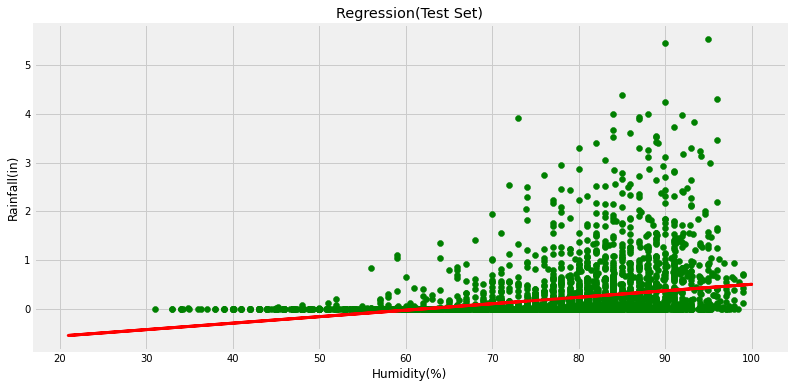

In [36]:
#plot straight line with the test data
plt.figure(figsize=(12,6))
plt.scatter(X_test,y_test,color="green") # Plot a graph with X_test vs y_test
plt.plot(X_train,regressor.predict(X_train),color="red",linewidth=3) # Regressior line showing
plt.title('Regression(Test Set)')
plt.xlabel('Humidity(%)')
plt.ylabel('Rainfall(in)')
plt.show()

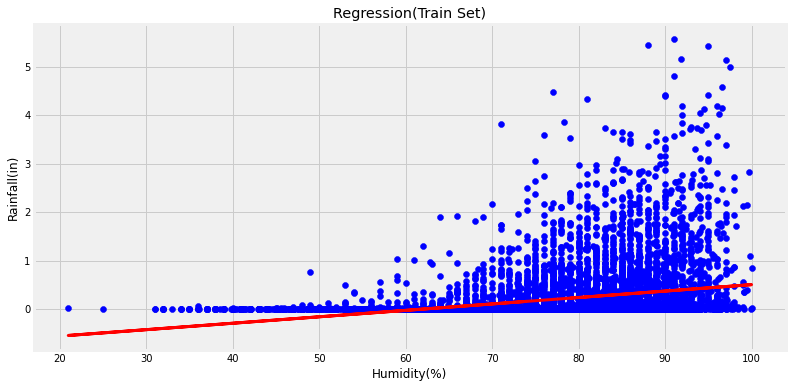

In [37]:
#plot straight line with the train data
plt.figure(figsize=(12,6))
plt.scatter(X_train,y_train,color="blue")  # Plot a graph with X_train vs y_train
plt.plot(X_train,regressor.predict(X_train),color="red",linewidth=3) # Regressior line showing
plt.title('Regression(Train Set)')
plt.xlabel('Humidity(%)')
plt.ylabel('Rainfall(in)')
plt.show()

In [40]:
#print mean absolute error, mean square error and root mean squared error
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('R2 score: %.2f' % r2_score(y_test,y_pred))

Mean Absolute Error: 0.23377162879300345
Mean Squared Error: 0.19414189516924327
Root Mean Squared Error: 0.44061535966105775
R2 score: 0.11


***We can see that the value of the root mean squared error is 0.4269 which is more than 10% of the mean value of 73.605187. It can be better but still can make good predictions.***

## Multiple Linear Regression

In the last section we used a simple linear regression that left off most of our dataset. Here we'll included the other variables and hopefully get better results.

In [41]:
#we'll use the same dataframe as before
df_lr.describe()

Dewpoint_temp(°F)   Humidity(%)  Sealevel_pressure(Hg)  Max_temp(°F)  \
count       18227.000000  18227.000000           18227.000000  18227.000000   
mean           60.490635     73.613779              30.049377     79.980743   
std            13.937013     11.390546               0.140199     12.203567   
min             4.708333     21.000000              29.440000     31.000000   
25%            52.000000     67.000000              29.960000     72.000000   
50%            64.422222     75.000000              30.036250     82.000000   
75%            72.000000     82.000000              30.130000     90.000000   
max            80.000000    100.000000              30.695417    109.000000   

       Min_temp(°F)  Average_temp(°F)  Wind_speed(mph)  Rainfall(in)  
count  18227.000000      18227.000000     18227.000000  18227.000000  
mean      61.399517         70.941022        22.751193      0.152772  
std       14.034267         12.751247         6.916459      0.459829  
min       16.000000         26.000000         0.000000      0.000000  
25%       51.000000         62.000000        18.000000      0.000000  
50%       65.000000         74.000000        22.000000      0.000000  
75%       74.000000         82.000000        26.000000      0.030000  
max       85.000000         95.000000       120.000000      5.580000

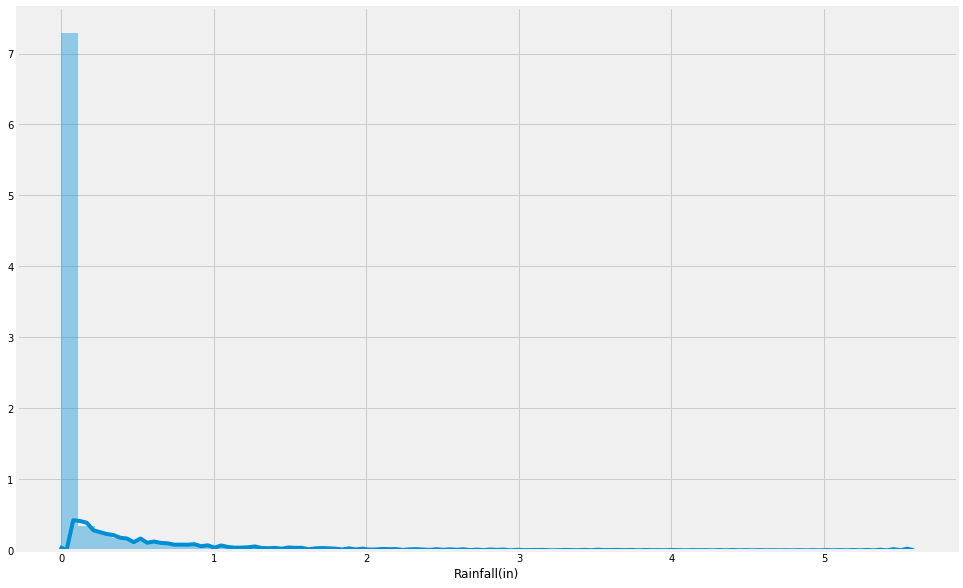

In [42]:
plt.figure(figsize=(15,10))
plt.tight_layout()
seabornInstance.distplot(df_lr['Rainfall(in)'])

In [43]:
#divide dataframe into independent variables(X) and dependent variables(y)
X = df_lr[['Dewpoint_temp(°F)', 'Humidity(%)', 'Sealevel_pressure(Hg)', 'Max_temp(°F)', 'Min_temp(°F)', 'Average_temp(°F)',
        'Wind_speed(mph)']]
y = df_lr['Rainfall(in)']

In [44]:
#split 70 of our dataset into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [45]:
#train our model
regressor = LinearRegression()  
regressor.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [46]:
#create dataframe of our features and their importances to dependent varaible(Rainfall)
coeff_df = pd.DataFrame(regressor.coef_, X.columns, columns=['Coefficient'])  

coeff_df

Coefficient
Dewpoint_temp(°F)        -0.015559
Humidity(%)               0.017883
Sealevel_pressure(Hg)    -0.220870
Max_temp(°F)             -0.001573
Min_temp(°F)              0.008934
Average_temp(°F)          0.005468
Wind_speed(mph)           0.019569

***For a unit incrase in Dewpoint temps, there is a decrease of -0.017 of Rainfall. A unit of decrease in Sealevel Pressure results a decrease of -0.22 ***

In [47]:
#predict test data
y_pred = regressor.predict(X_test)

In [48]:
#difference between actual value and predicted value
dlf = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
dlf1 = dlf.head(25)
dlf1

Actual  Predicted
2608     0.00   0.143781
435      0.00   0.236913
11371    0.01   0.341327
18241    0.00   0.303154
13990    0.00  -0.158151
9475     0.37   0.580833
4015     0.00  -0.075972
13639    0.21   0.291810
2054     0.92   0.680859
14393    0.00  -0.146894
14179    1.35   0.293004
7409     0.00   0.579292
15804    0.00   0.030733
6979     0.00   0.244087
14762    0.00   0.137295
2398     0.00   0.049927
16373    0.86   0.608706
12581    0.15   0.329029
9790     0.00   0.130785
1336     0.00   0.076634
14808    0.01   0.115232
10955    0.00  -0.162420
2764     0.00  -0.026998
15089    0.00  -0.014517
1482     0.04   0.377720

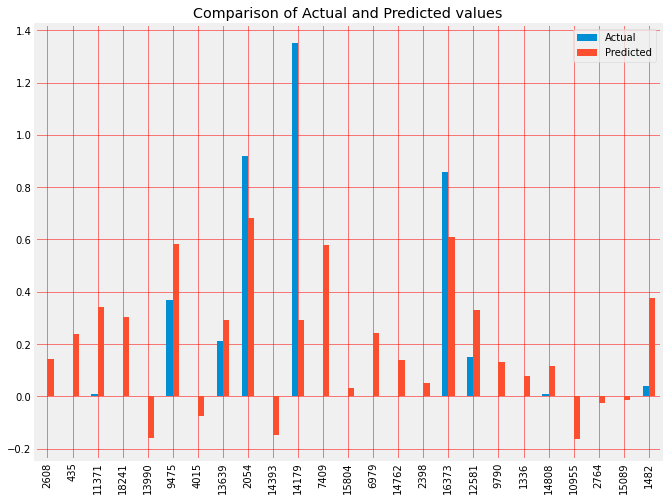

In [49]:
#plot camparison of Actual and Predicted values
dlf1.plot(kind='bar',figsize=(10,8))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='red')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.title('Comparison of Actual and Predicted values')
plt.show()

***Our prediction model is not very precise. The predicted percentages are close to the actual on a few occassions but far off on others***

In [50]:
#print mean absolute error, mean square error and root mean squared error
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('R2 score: %.2f' % r2_score(y_test,y_pred))

Mean Absolute Error: 0.22021986657966428
Mean Squared Error: 0.1729239892490568
Root Mean Squared Error: 0.41584130296190736
R2 score: 0.21


***Root mean square error is 0.40 which is higher than the Rainfall mean value.***


***There are many factors that could contribute to our inaccuracy. We could use more data features to see if there are any other factors that have a more positive co-efficiency with predicting rainfall.***

## XGBoost

In [51]:
import xgboost

# drop inconsequential features
X = df_lr[['Dewpoint_temp(°F)', 'Humidity(%)', 'Sealevel_pressure(Hg)', 'Max_temp(°F)', 'Min_temp(°F)', 'Average_temp(°F)',
        'Wind_speed(mph)']]
y = df_lr['Rainfall(in)']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=30)

model = xgboost.XGBRegressor(objective ='reg:squarederror', max_depth = 3, learning_rate = 0.05) 
model.fit(X_train, y_train)

C:\Users\Jimsyd\Anaconda3\lib\site-packages\dask\dataframe\utils.py:14: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.05, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
             validate_parameters=False, verbosity=None)

In [52]:
#split 70 of our dataset into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 23)

model = xgboost.XGBRegressor(objective ='reg:squarederror', max_depth = 3, learning_rate = 0.05) 

model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.05, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
             validate_parameters=False, verbosity=None)

In [55]:
#
parameters_for_testing = {
    'min_child_weight':[1,2,3],
    'learning_rate':[0.1,0.07,0.05],
    'max_depth':[3,5],
}

                    
xgb_model = xgboost.XGBRegressor(objective = 'reg:squarederror', learning_rate =0.1, n_estimators=1000, max_depth=5,
     min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8, nthread=6, scale_pos_weight=1, seed=15)

gsearch1 = GridSearchCV(cv = 5, estimator = xgb_model, param_grid = parameters_for_testing, 
                        n_jobs=6,iid=False, verbose=10,scoring='r2')
gsearch1.fit(X_train,y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   1 tasks      | elapsed:   29.5s
[Parallel(n_jobs=6)]: Done   6 tasks      | elapsed:   29.9s
[Parallel(n_jobs=6)]: Done  13 tasks      | elapsed:  1.1min
[Parallel(n_jobs=6)]: Done  20 tasks      | elapsed:  1.6min
[Parallel(n_jobs=6)]: Done  29 tasks      | elapsed:  2.3min
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:  2.7min
[Parallel(n_jobs=6)]: Done  49 tasks      | elapsed:  3.5min
[Parallel(n_jobs=6)]: Done  60 tasks      | elapsed:  4.2min
[Parallel(n_jobs=6)]: Done  73 tasks      | elapsed:  5.0min
[Parallel(n_jobs=6)]: Done  90 out of  90 | elapsed:  6.1min finished
C:\Users\Jimsyd\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:823: FutureWarning:

The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.



GridSearchCV(cv=5, error_score=nan,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None, colsample_bytree=0.8,
                                    gamma=0, gpu_id=None,
                                    importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=0.1, max_delta_step=None,
                                    max_depth=5, min_child_weight=1,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=1000, n...
                                    objective='reg:squarederror',
                                    random_state=None, reg_alpha=None,
                                    reg_lambda=None, scale_pos_weight=1,
                                    seed=15, subsample=0.8, tree_method=None,
   

In [56]:
print('best params')
print (gsearch1.best_params_)
print('best score')
print (gsearch1.best_score_)

best params
{'learning_rate': 0.05, 'max_depth': 3, 'min_child_weight': 1}
best score
0.28255516175364637


In [57]:
xgb_feature_importances = pd.DataFrame({'feature': X.columns,
                                        'importance': model.feature_importances_}).sort_values('importance',
                                                                                               ascending=False)
xgb_feature_importances.head(10)

feature  importance
1            Humidity(%)    0.352659
6        Wind_speed(mph)    0.284399
2  Sealevel_pressure(Hg)    0.104176
0      Dewpoint_temp(°F)    0.089147
4           Min_temp(°F)    0.086994
5       Average_temp(°F)    0.049457
3           Max_temp(°F)    0.033167

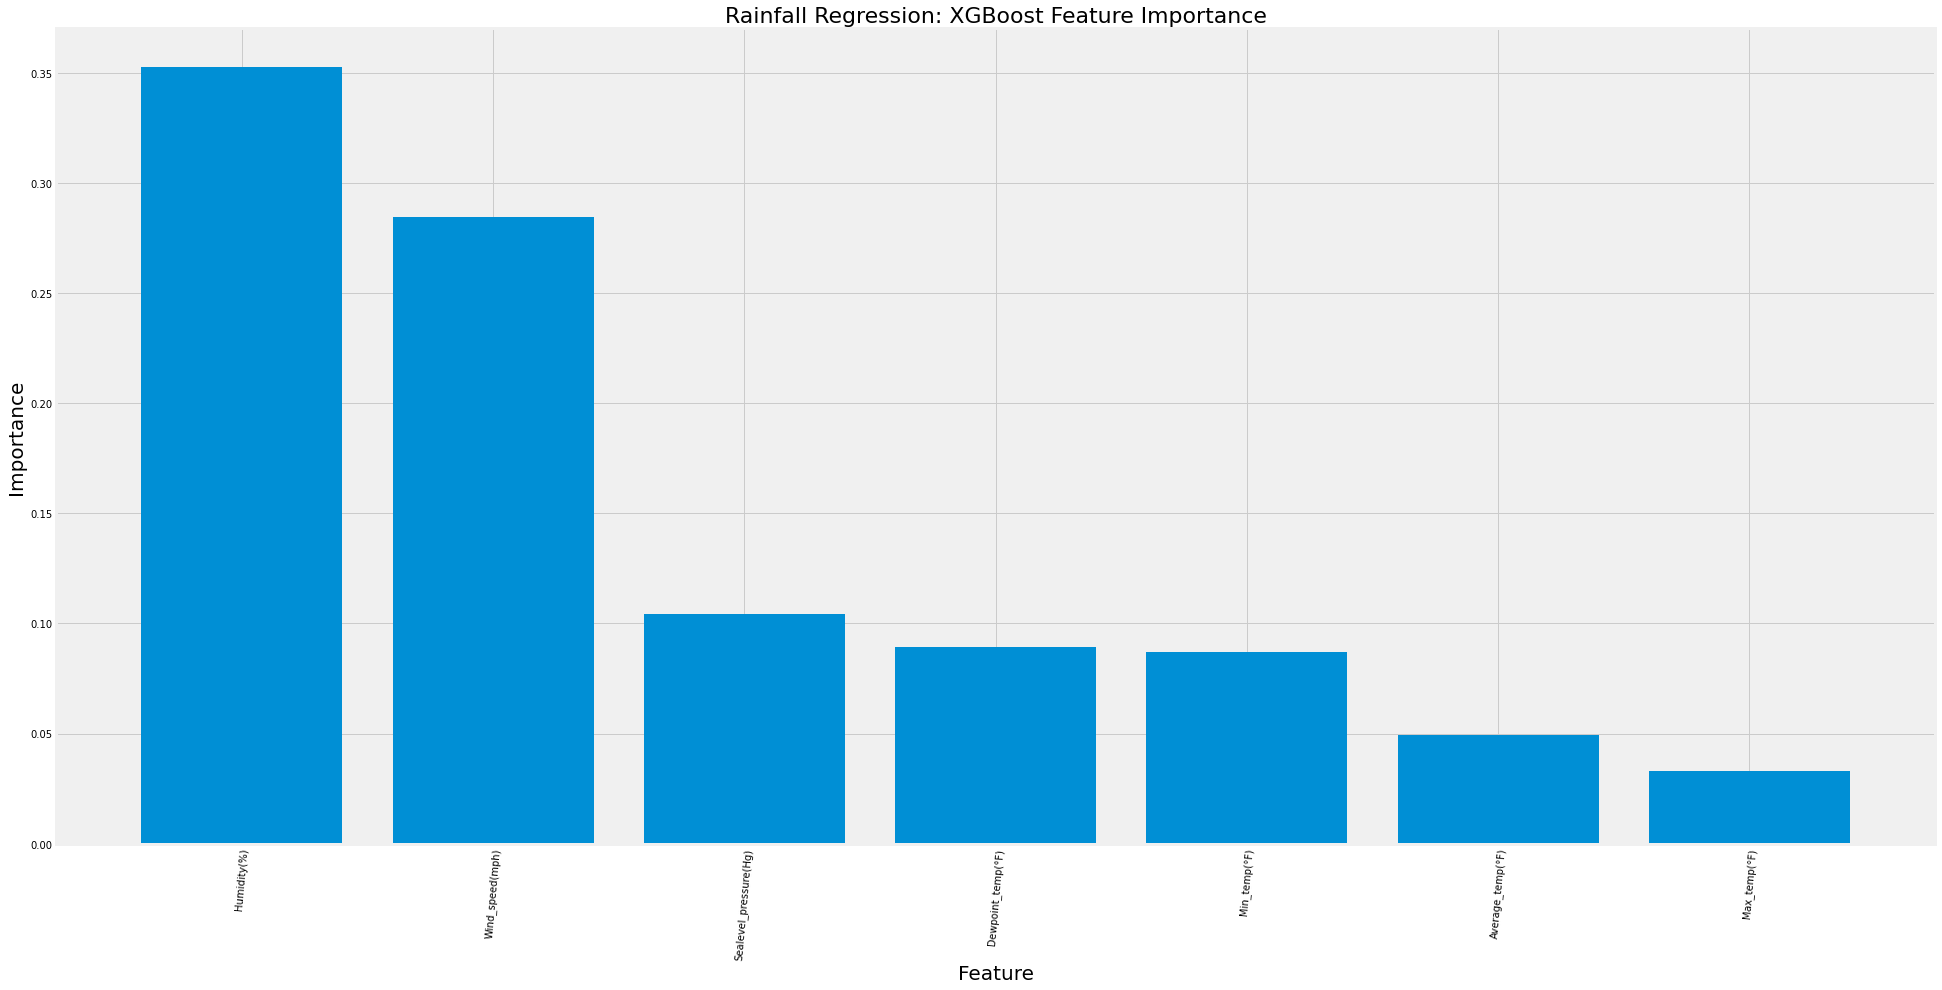

In [58]:
plt.bar(xgb_feature_importances.feature[:10], xgb_feature_importances.importance[:10])
plt.xlabel('Feature', fontsize=20)
plt.ylabel('Importance', fontsize= 20)
plt.xticks(xgb_feature_importances.feature[:10], rotation = 85)
plt.title('Rainfall Regression: XGBoost Feature Importance', fontsize=22)
plt.show()

In [59]:
#predict model
model.predict(X_test)

#model test score
xgb_rsq = model.score(X_test, y_test)
print('Test score:', xgb_rsq)

#model train score
xgb_rss = model.score(X_train, y_train)
print('Train score:', xgb_rss)

Test score: 0.3349890674825159
Train score: 0.37371109142678455


***Our test and training scores means our model isn't too overfit.***

***Our feature importance seem to keep in line with our other models and correlation heatmaps with rainfall. Humidity has usually been at or near the top. Dewpoint seems to be a bit lower than usual.***

***Our score is a bit low. We could add other outside features to see if it would increase our score.***

## Random Forest Regression

In [79]:
#using the same dataset as with our other models

# drop inconsequential features
X = df_lr[['Dewpoint_temp(°F)', 'Humidity(%)', 'Sealevel_pressure(Hg)', 'Max_temp(°F)', 'Min_temp(°F)', 'Average_temp(°F)',
        'Wind_speed(mph)']]
y = df_lr['Rainfall(in)']

#split 70 of our dataset into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=23)

# create regressor object
rf = RandomForestRegressor(n_estimators=100, random_state=23)

# fit the regressor with x and y data
rf.fit(X_train, y_train)

#predict our model
y_pred = rf.predict(X_test)

#test score of our model
rf_rsq = rf.score(X_test, y_test)

print('Model R-squared:', round(rf_rsq, 3))

Model R-squared: 0.295


In [80]:
rf_feat_df = pd.DataFrame({'feature': X.columns, 'importance': rf.feature_importances_}
             ).sort_values('importance', ascending=False)
rf_feat_df['rank'] = range(1,len(rf_feat_df)+1)
rf_feat_df.head(10)

feature  importance  rank
1            Humidity(%)    0.280706     1
6        Wind_speed(mph)    0.207728     2
2  Sealevel_pressure(Hg)    0.150124     3
0      Dewpoint_temp(°F)    0.107117     4
3           Max_temp(°F)    0.094892     5
4           Min_temp(°F)    0.093473     6
5       Average_temp(°F)    0.065959     7

***The order of our features are in the same order as before but their importance have dropped slightly***

In [81]:
clf = RandomForestRegressor(n_estimators=100)
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.30382655128739267

In [82]:
print('Training Features Shape:', X_test.shape)
print('Training Labels Shape:', y_test.shape)
print('Testing Features Shape:', X_train.shape)
print('Testing Labels Shape:', y_train.shape)

Training Features Shape: (3646, 7)
Training Labels Shape: (3646,)
Testing Features Shape: (14581, 7)
Testing Labels Shape: (14581,)


In [83]:
# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)
# Train the model on training data
rf.fit(X_train, y_train);

In [84]:
# Use the forest's predict method on the test data
predictions = rf.predict(X_test)
# Calculate the absolute errors
errors = abs(predictions - y_test)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

Mean Absolute Error: 0.17 degrees.


***Our average estimate is off by 0.16 degrees which is under the baseline.***

In [85]:
#create list of X columns
feature_list = list(X.columns)

# Get numerical feature importances
importances = list(rf.feature_importances_)

# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]

# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: Humidity(%)          Importance: 0.28
Variable: Wind_speed(mph)      Importance: 0.21
Variable: Sealevel_pressure(Hg) Importance: 0.15
Variable: Dewpoint_temp(°F)    Importance: 0.11
Variable: Max_temp(°F)         Importance: 0.09
Variable: Min_temp(°F)         Importance: 0.09
Variable: Average_temp(°F)     Importance: 0.07


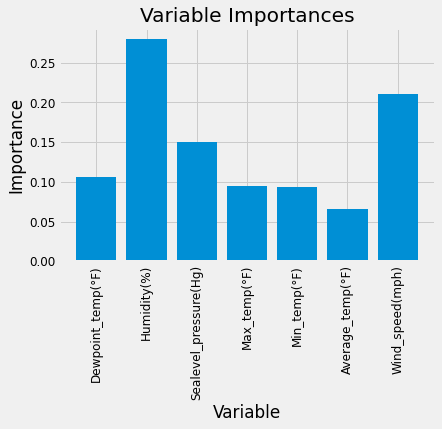

In [86]:
# Import matplotlib for plotting and use magic command for Jupyter Notebooks
import matplotlib.pyplot as plt
%matplotlib inline
# Set the style
plt.style.use('fivethirtyeight')
# list of x locations for plotting
x_values = list(range(len(importances)))
# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical')
# Tick labels for x axis
plt.xticks(x_values, feature_list, rotation='vertical')
# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');

***Bar plot of the feature importances to show the disparities in the relative significance of the variables. As mentioned before Humidity and Windspeed show the highest importance levels***

In [69]:
# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / y_test)
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

Accuracy: -inf %.


In [87]:
def percentage_error(actual, predicted):
    res = np.empty(actual.shape)
    for j in range(actual.shape[0]):
        if actual[j] != 0:
            res[j] = (actual[j] - predicted[j]) / actual[j]
        else:
            res[j] = predicted[j] / np.mean(actual)
    return res

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs(percentage_error(np.asarray(y_true), np.asarray(y_pred)))) * 100

In [89]:
mean_absolute_percentage_error(y_true, y_pred)

144.48012911946077

In [70]:
# New random forest with only the two most important variables
rf_most_important = RandomForestRegressor(n_estimators= 1000, random_state=42)

# Extract the two most important features
important_indices = [feature_list.index('Humidity(%)'), feature_list.index('Wind_speed(mph)')]
train_important = X_train.iloc[:, important_indices]
test_important = X_test.iloc[:, important_indices]

# Train the random forest
rf_most_important.fit(train_important, y_train)

# Make predictions and determine the error
predictions = rf_most_important.predict(test_important)
errors = abs(predictions - y_test)

# Display the performance metrics
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')
mape = np.mean(100 * (errors / y_test))
accuracy = 100 - mape

print('Accuracy:', round(accuracy, 2), '%.')

Mean Absolute Error: 0.17 degrees.
Accuracy: -inf %.


In [71]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [72]:
regressor = RandomForestRegressor(n_estimators=20, random_state=0)
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)

In [73]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 0.16891801060522948
Mean Squared Error: 0.1525043380429085
Root Mean Squared Error: 0.39051803805062385


# Scratch Notebook

In [116]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import matplotlib
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

In [117]:
df = pd.read_csv('df_clean.csv')

In [118]:
df1= df.copy()

In [119]:
#Convert string DATE into readable datetime object
df1['datetime'] = pd.to_datetime(df1['datetime'])

In [120]:
df1['datetime'].min(), df1['datetime'].max()

(Timestamp('2010-01-01 00:00:00'), Timestamp('2019-12-31 00:00:00'))

In [121]:
df1.sort_values('Rainfall(in)')

City   datetime  Dewpoint_temp(°F)  Humidity(%)  \
0          Houston 2010-01-01          35.000000    65.000000   
11060   Pascagoula 2010-04-26          58.000000    88.000000   
11061   Pascagoula 2010-04-27          58.000000    43.000000   
11062   Pascagoula 2010-04-28          47.000000    66.000000   
11063   Pascagoula 2010-04-29          55.000000    70.000000   
...            ...        ...                ...          ...   
9416   New_Orleans 2015-10-25          70.000000    84.000000   
3545       Houston 2019-09-19          74.000000    91.000000   
2296       Houston 2016-04-18          65.000000    96.000000   
5224        Mobile 2014-04-29          66.350515    95.206186   
2792       Houston 2017-08-27          74.000000    95.000000   

       Sealevel_pressure(Hg)  Max_temp(°F)  Min_temp(°F)  Average_temp(°F)  \
0                   30.40000          56.0          38.0              47.0   
11060               29.73000          79.0          60.0              70.0   
11061               29.86000          79.0          60.0              70.0   
11062               30.02000          74.0          44.0              59.0   
11063               29.98000          77.0          48.0              63.0   
...                      ...           ...           ...               ...   
9416                29.82000          78.0          72.0              75.0   
3545                29.88000          82.0          74.0              78.0   
2296                30.02000          70.0          64.0              67.0   
5224                29.76125          78.0          62.0              70.0   
2792                29.75000          77.0          74.0              76.0   

       Wind_speed(mph)  Rainfall(in)  
0                 26.0          0.00  
11060              0.0          0.00  
11061             23.0          0.00  
11062             17.0          0.00  
11063             24.0          0.00  
...                ...           ...  
9416              46.0          8.67  
3545              43.0          9.21  
2296              36.0          9.92  
5224              40.0          9.94  
2792              35.0         16.07  

[18243 rows x 10 columns]

In [122]:
df1 = df1.set_index('datetime')
df1.index

DatetimeIndex(['2010-01-01', '2010-01-02', '2010-01-03', '2010-01-04',
               '2010-01-05', '2010-01-06', '2010-01-07', '2010-01-08',
               '2010-01-09', '2010-01-10',
               ...
               '2019-12-22', '2019-12-23', '2019-12-24', '2019-12-25',
               '2019-12-26', '2019-12-27', '2019-12-28', '2019-12-29',
               '2019-12-30', '2019-12-31'],
              dtype='datetime64[ns]', name='datetime', length=18243, freq=None)

In [123]:
y1 = df1['Rainfall(in)'].resample('MS').mean()

In [124]:
df1.drop('City', axis=1, inplace=True)
df1

Dewpoint_temp(°F)  Humidity(%)  Sealevel_pressure(Hg)  \
datetime                                                            
2010-01-01               35.0         65.0                  30.40   
2010-01-02               32.0         66.0                  30.33   
2010-01-03               35.0         72.0                  30.26   
2010-01-04               29.0         62.0                  30.41   
2010-01-05               26.0         65.0                  30.43   
...                       ...          ...                    ...   
2019-12-27               65.0         78.0                  30.10   
2019-12-28               67.0         80.0                  30.05   
2019-12-29               69.0         83.0                  30.00   
2019-12-30               68.0         83.0                  29.97   
2019-12-31               46.0         57.0                  30.08   

            Max_temp(°F)  Min_temp(°F)  Average_temp(°F)  Wind_speed(mph)  \
datetime                                                                    
2010-01-01          56.0          38.0              47.0             26.0   
2010-01-02          56.0          31.0              44.0             15.0   
2010-01-03          49.0          37.0              43.0             14.0   
2010-01-04          48.0          34.0              41.0             25.0   
2010-01-05          50.0          28.0              39.0             18.0   
...                  ...           ...               ...              ...   
2019-12-27          77.0          67.0              72.0             23.0   
2019-12-28          80.0          69.0              75.0             21.0   
2019-12-29          81.0          72.0              77.0             20.0   
2019-12-30          77.0          70.0              74.0             22.0   
2019-12-31          71.0          56.0              64.0             17.0   

            Rainfall(in)  
datetime                  
2010-01-01          0.00  
2010-01-02          0.00  
2010-01-03          0.00  
2010-01-04          0.00  
2010-01-05          0.00  
...                  ...  
2019-12-27          0.00  
2019-12-28          0.32  
2019-12-29          0.07  
2019-12-30          0.00  
2019-12-31          0.00  

[18243 rows x 8 columns]

In [ ]:
y1['2017':]

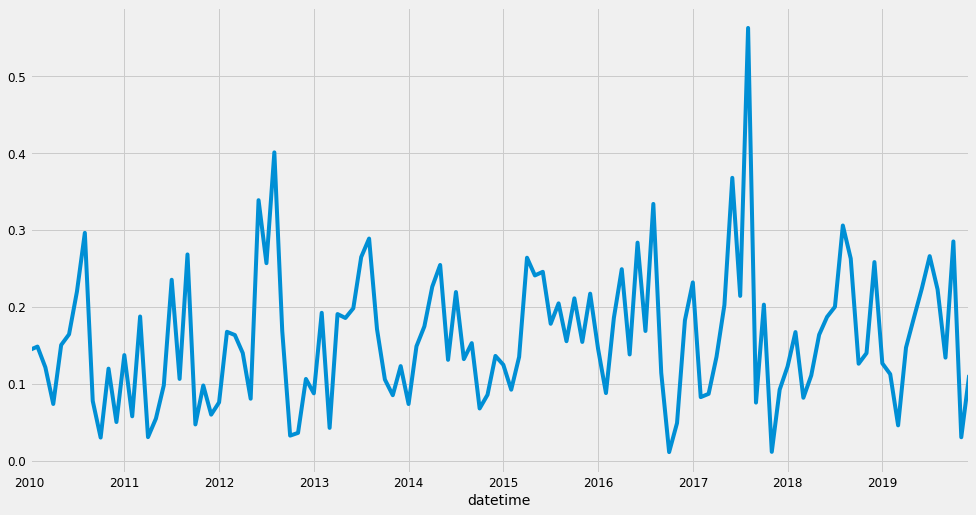

In [125]:
y1.plot(figsize=(15,8))
plt.show()

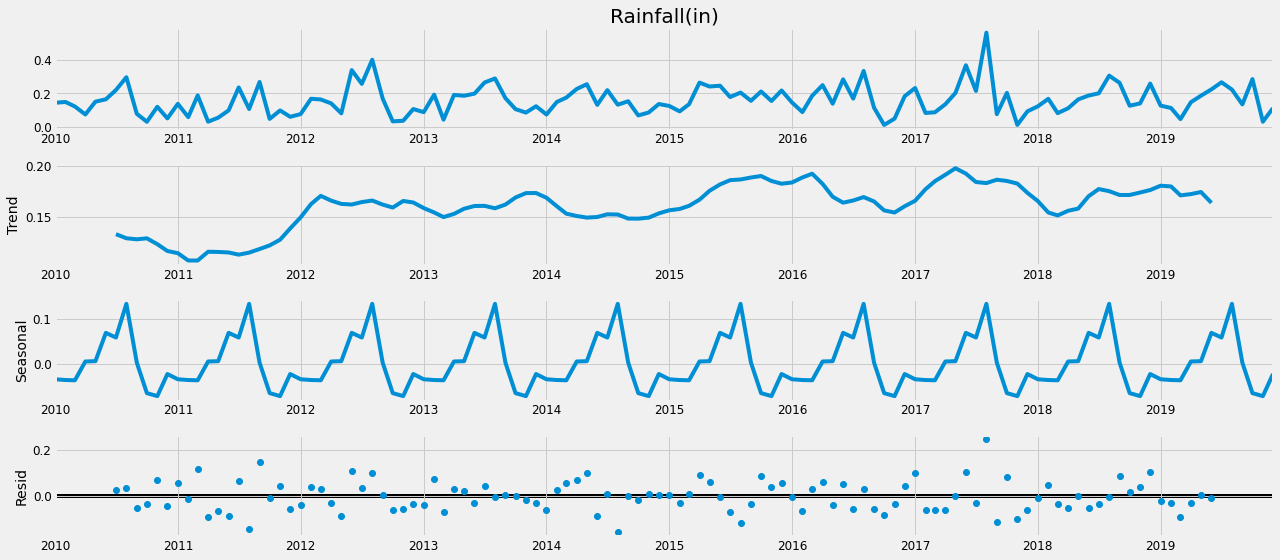

In [126]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y1, model='additive')
fig = decomposition.plot()
plt.show()

In [127]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [ ]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:25313.960479303292
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:25139.284118620395
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:35909.74374042677
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:23469.555800747217
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:25111.14180783467
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:23482.896683274397
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:30763.9026969768
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:23471.55553237157
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:24469.330925906164
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:24381.38218906161
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:35610.83352587319
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:23093.30107565714
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:24371.549697391107
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:23106.623180815142
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:30448.37045183213
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:23095.30138653208
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:33120.94309762036
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:33109.43476834532
ARIM

In [ ]:
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary().tables[1])

In [ ]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

In [ ]:
pred = results.get_prediction(start=('2010-01-01'), dynamic=False)
pred_ci = pred.conf_int()

ax = y1['2014':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Rainfall(in)')
plt.legend()

plt.show()

In [ ]:
y_forecasted = pred.predicted_mean
y_truth = y1['2017-01-01':]

# Compute the mean square error
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

In [ ]:
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

In [ ]:
pred_uc = results.get_forecast(steps=100)
pred_ci = pred_uc.conf_int()

ax = y1.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')

plt.legend()
plt.show()

In [ ]:
df2 = df.copy()
#create a new column to show rain(1) or no rain(0) days
df2['Rain or Not'] = np.where(df2['Rainfall(in)'] > 0, 1, 0)

df2

In [ ]:
#Convert string DATE into readable datetime object
df2['datetime'] = pd.to_datetime(df2['datetime'])

In [ ]:
rain = df['Rainfall(in)']
dew = df[''] == 0]

In [ ]:
rain = df2.loc[df2['Rain or Not'] == 1]
ew = df2.loc[df2['Rain or Not'] == 0]

In [ ]:
no_rain

In [ ]:
rain= df[['City', 'datetime', 'Rainfall(in)', 'Dewpoint_temp(°F)']]
dew = df[['City', 'datetime', 'Rainfall(in)', 'Dewpoint_temp(°F)']]

In [ ]:
rain.drop('City', axis=1, inplace=True)
dew.drop('City', axis=1, inplace=True)

rain= rain.sort_values('datetime')
dew = dew.sort_values('datetime')

In [ ]:
rain.shape, dew.shape

In [ ]:
dew

In [ ]:
rain = rain.set_index('datetime')
dew = dew.set_index('datetime')

y_rain = rain['Rainfall(in)'].resample('MS').mean()
y_dew = dew['Dewpoint_temp(°F)'].resample('MS').mean()

rain= pd.DataFrame({'datetime':y_rain.index, 'Rainfall(in)':y_rain.values})
dew= pd.DataFrame({'datetime':y_dew.index, 'Dew':y_dew.values})

In [ ]:
dew

In [ ]:
total = rain.merge(dew, how='inner', on='datetime')
#total.rename(columns={'Rain or Not_x': 'Rainfall', 'Rain or Not_y': 'No_Rainfall'}, inplace=True)
total.head()

In [ ]:
plt.figure(figsize=(20, 8))
plt.plot(total['datetime'], total['Rainfall(in)'], 'b-', label = 'Rainfall')
plt.plot(total['datetime'], total['Dew'], 'r-', label = 'Dew')
plt.xlabel('Date'); plt.ylabel('Sales'); plt.title('Sales of Furniture and Office Supplies')
plt.legend();

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

In [ ]:
df5 = df.copy()

In [ ]:
df5.head(3)

In [ ]:
e = df5.iloc[:,2:].head(5)
e

In [ ]:
creation = df5.iloc[:,2:]
labels=np.array(creation['Rainfall(in)'])
creation=creation.drop('Rainfall(in)',axis=1)
creation_list=list(creation.columns)
creation=np.array(creation)

In [ ]:
train_creation, test_creation, train_labels, test_labels= train_test_split(creation,labels, test_size=0.30,random_state=4)

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score
from sklearn.externals import joblib
from sklearn.preprocessing import RobustScaler

import csv
import datetime
from math import sqrt
from sklearn.svm import SVR
import sklearn.svm as svm
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error


from collections import Counter
from sklearn.ensemble import GradientBoostingClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, recall_score, roc_curve,precision_recall_curve, precision_score, confusion_matrix, classification_report

In [ ]:
df_time = pd.get_dummies(df_time, drop_first=True)
df_time

In [ ]:
df_time = df.copy()
df_time['Day'] = df_time['datetime'].dt.day
df_time['Week'] = df_time['datetime'].dt.week
df_time['Month'] = df_time['datetime'].dt.month
df_time['Year'] = df_time['datetime'].dt.year

df_time.head()

In [ ]:
df_time.shape

In [ ]:
df = pd.read_csv('df_clean.csv')

In [ ]:
#Convert string DATE into readable datetime object
df['datetime'] = pd.to_datetime(df['datetime'])

In [ ]:
df_time

In [ ]:
#we see that the outliers are mainly found above 7 inches of rain so we'll remove them from our dataset
df_time = df_time[df_time['Rainfall(in)'] < 7]
df_time.shape

In [ ]:
df7 = df.copy()
df7

In [ ]:
df7.drop('City', axis=1, inplace=True)

In [ ]:
df7 = df7.set_index('datetime')
#rain = rain.set_index('datetime')
df7

In [ ]:
#we see that the outliers are mainly found above 7 inches of rain so we'll remove them from our dataset
df7 = df7[df7['Rainfall(in)'] < 7]
df7.shape

In [ ]:
y= df7['Rainfall(in)']
X= df7.drop('Rainfall(in)', axis=1)

In [ ]:
from sklearn.ensemble import RandomForestRegressor

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=23)  # 70% training and 30% test

# create regressor object
rf = RandomForestRegressor(n_estimators=100, random_state=23)

# fit the regressor with x and y data
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

rf_rsq = rf.score(X_test, y_test)

print('Model R-squared:', round(rf_rsq, 3))

In [ ]:
rf_feat_df = pd.DataFrame({'feature': X.columns, 'importance': rf.feature_importances_}
             ).sort_values('importance', ascending=False)
rf_feat_df['rank'] = range(1,len(rf_feat_df)+1)
rf_feat_df

In [ ]:
from sklearn.svm import SVR
# Spot Check Algorithms
models = []
models.append(('LR', LogisticRegression()))
models.append(('RF', RandomForestClassifier()))
models.append(('SVM', SVR()))

In [ ]:
df8 = df7.copy()

In [ ]:
df8.head(2)

In [ ]:
df8['Day'] = df8['datetime'].dt.day
df8['Month'] = df8['datetime'].dt.month
df8['Year'] = df8['datetime'].dt.year

In [ ]:
X1 = df8.drop('Rain or Not', axis=1)
y1 = df8['Rain or Not']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.30, random_state=0)

In [ ]:
# list of models to try
models = []
#models.append(('KNN', KNeighborsRegressor()))
models.append(('LR', LinearRegression()))
models.append(('RF', RandomForestClassifier()))

In [ ]:
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

# train test check
def train_test():
    names = []
    scores = []
    AUC=[]
    Log_loss=[]
    for name, model in tqdm(models):
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_pred_prob=model.predict_proba(X_test)[:, 1]
        fpr, tpr, thresholds=roc_curve(y_test, y_pred_prob)
        roc_auc = auc(fpr, tpr)
        scores.append(accuracy_score(y_test, y_pred))
        AUC.append(roc_auc)
        names.append(name)
        Log_loss.append(round(log_loss(y_test, y_pred),4))
    tr_split = pd.DataFrame({'Name': names, 'Accuracy': scores,'AUC':AUC,'Log_loss':Log_loss})
    print(tr_split)

In [ ]:
def cross_val():
    names = []
    scores = []

    # cross val check
    for name, model in tqdm(models):
        kfold = KFold(n_splits=10, random_state=10) 
        score = cross_val_score(model, X1, y1, cv=kfold, scoring='roc_auc').mean()
        names.append(name)
        scores.append(score)
    kf_cross_val = pd.DataFrame({'Name': names, 'AUC score': scores})
    print(kf_cross_val)

In [ ]:
train_test()

In [ ]:
cross_val()

In [ ]:
# Creating the logistic regression model

# Helper function to normalize data
def normalize(X):
    return X - X.mean()

# Method to make predictions
def predict(X, b0, b1):
    return np.array([1 / (1 + exp(-1*b0 + -1*b1*x)) for x in X])

# Method to train the model
def logistic_regression(X, Y):

    X = normalize(X)

    # Initializing variables
    b0 = 0
    b1 = 0
    L = 0.001
    epochs = 300

    for epoch in range(epochs):
        y_pred = predict(X, b0, b1)
        D_b0 = -2 * sum((Y - y_pred) * y_pred * (1 - y_pred))  # Derivative of loss wrt b0
        D_b1 = -2 * sum(X * (Y - y_pred) * y_pred * (1 - y_pred))  # Derivative of loss wrt b1
        # Update b0 and b1
        b0 = b0 - L * D_b0
        b1 = b1 - L * D_b1
    
    return b0, b1

In [ ]:
# Making predictions using scikit learn
from sklearn.linear_model import LogisticRegression

X_train, X_test, y_train, y_test = train_test_split(df7['Dewpoint_temp(°F)'], df7['Rain or Not'], test_size=0.30)


# Create an instance and fit the model 
lr_model = LogisticRegression()
lr_model.fit(X_train.values.reshape(-1, 1), y_train.values.reshape(-1, 1))

# Making predictions
y_pred_sk = lr_model.predict(X_test.values.reshape(-1, 1))

plt.clf()
plt.scatter(X_test, y_test)
plt.scatter(X_test, y_pred_sk, c="red")
plt.show()

# Accuracy
print(f"Accuracy = {lr_model.score(X_test.values.reshape(-1, 1), y_test.values.reshape(-1, 1))}")

In [ ]:
# generate a no opioid prescription prediction (majority class)
ns_probs = [0 for _ in range(len(y_test))]

# predict probabilities
lr_probs = clf.predict_proba(X_test)

# keep probabilities for the positive outcome (opioid prescribed) only
lr_probs = lr_probs[:, 1]

# calculate scores
ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, lr_probs)

# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))

# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)

# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='Non Opioid Prescribers')
plt.plot(lr_fpr, lr_tpr, marker='.', label='Random Forest')


# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

In [ ]:
from sklearn.ensemble import RandomForestClassifier as RF
clf = RF()
clf.fit(X, y)

In [ ]:
df.dtypes

In [ ]:
df7

In [ ]:
#Data manipulation libraries : 
import numpy as np  #numpy
import pandas as pd  #pandas
import tensorflow as tf
#System libraries
import glob #The glob module finds all the pathnames matching a specified pattern according to the rules used by the Unix shell

#Map plotting 
import folium #Interactive Maps viz



#Plotting
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

#math operations lib 
import math
from math import pi

#date manipulation 
import datetime as dt

#Missing data detector lib
import missingno as mn

#Impute missing data
#from sklearn.preprocessing import Imputer 

#Deep learning with keras
from keras import backend as K
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout

#Splitting data to test and train 
from sklearn.model_selection import train_test_split

import datetime
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from tensorflow import keras
%matplotlib inline
plt.style.use('seaborn-whitegrid')

from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
from collections import Counter
import time
import datetime as dt
from datetime import datetime
import collections
import os # accessing directory structure
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
from matplotlib.pyplot import rcParams

from sklearn import linear_model

In [ ]:
quantitative = df7.select_dtypes(include = ["int64","float64"]).keys()
print(quantitative)

In [ ]:
rcParams['figure.figsize'] = 9, 9
df7[quantitative].hist()

In [ ]:
plt.figure(figsize=(18,8)) # this creates a figure 8 inch wide, 4 inch high
sns.pairplot(df7[['Average_temp(°F)','Rainfall(in)', 'Humidity(%)' ]])
plt.show()

In [ ]:
df7 = df7.copy()
df7['Day'] = df7['datetime'].dt.day
df7['Month'] = df7['datetime'].dt.month
df7['Year'] = df7['datetime'].dt.year

In [ ]:
df7.drop('datetime', axis=1, inplace=True)
df7['Rain or Not'] = np.where(df7['Rainfall(in)'] > 0, 1, 0)

In [ ]:
df7.head(2)

In [ ]:
print("Linear Regression")
ls.fit(X_train, y_train)
print("alpha = ",ls.coef_[0])
print("beta = ",ls.intercept_)
print("\n\nCalculating some regression quality metrics")
y_pred = ls.predict(X_test)
print("MSE = ",mean_squared_error(y_test, y_pred))
print("R2 = ",r2_score(y_test, y_pred))

In [ ]:
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

ls = linear_model.LinearRegression()



X = df7.drop("Rain or Not", axis=1)
y = df7["Rain or Not"]

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.30, 
                                                    random_state= 128)

In [ ]:
dtClassifer = DecisionTreeClassifier(max_leaf_nodes=15,random_state=0)

In [ ]:
dtClassifer.fit(X_train, y_train)

In [ ]:
prediction = dtClassifer.predict(X_test)

In [ ]:
prediction[:100]

In [ ]:
y_test[:100]

In [ ]:
accuracy_score(y_true=y_test, y_pred=prediction)

In [ ]:
lrClassifier = LogisticRegression()

In [ ]:
lrClassifier.fit(X_train,y_train)

In [ ]:
prediction = lrClassifier.predict(X_test)

In [ ]:
prediction[:3000]

In [ ]:
y_test[:100]

In [ ]:
accuracy_score(y_true=y_test, y_pred=prediction)

In [ ]:
data_neur= df7

In [ ]:
from statsmodels.tsa.stattools import adfuller

print(" > Is the data stationary ?")
dftest = adfuller(df7['Rainfall(in)'], autolag='AIC')
print("Test statistic = {:.3f}".format(dftest[0]))
print("P-value = {:.3f}".format(dftest[1]))
print("Critical values :")
for k, v in dftest[4].items():
    print("\t{}: {} - The data is {} stationary with {}% confidence".format(k, v, "not" if v<dftest[0] else "", 100-int(k[:-1])))
    
print("\n > Is the de-trended data stationary ?")
dftest = adfuller(df7['Rain or Not'].dropna(), autolag='AIC')
print("Test statistic = {:.3f}".format(dftest[0]))
print("P-value = {:.3f}".format(dftest[1]))
print("Critical values :")
for k, v in dftest[4].items():
    print("\t{}: {} - The data is {} stationary with {}% confidence".format(k, v, "not" if v<dftest[0] else "", 100-int(k[:-1])))
    
print("\n > Is the 12-lag differenced de-trended data stationary ?")
dftest = adfuller(df7['Humidity(%)'], autolag='AIC')
print("Test statistic = {:.3f}".format(dftest[0]))
print("P-value = {:.3f}".format(dftest[1]))
print("Critical values :")
for k, v in dftest[4].items():
    print("\t{}: {} - The data is {} stationary with {}% confidence".format(k, v, "not" if v<dftest[0] else "", 100-int(k[:-1])))


In [ ]:
fig, ax = plt.subplots(2, sharex=True, figsize=(12,6))
ax[0].plot(df7['Rainfall(in)'].values);
ax[0].set_title("Raw data");
ax[1].plot(np.log(df7['Rainfall(in)'].values));
ax[1].set_title("Logged data (deflated)");
ax[1].set_ylim(0, 15);

fig, ax = plt.subplots(2, 2, figsize=(12,6))
first_diff = (np.log(df7['Rainfall(in)'])- np.log(df7['Rainfall(in)']).shift()).dropna()
ax[0, 0] = plot_acf(np.log(df7['Rainfall(in)']), ax=ax[0, 0], lags=20, title="ACF - Logged data")
ax[1, 0] = plot_pacf(np.log(df7['Rainfall(in)']), ax=ax[1, 0], lags=20, title="PACF - Logged data")
ax[0, 1] = plot_acf(first_diff , ax=ax[0, 1], lags=20, title="ACF - Differenced Logged data")
ax[1, 1] = plot_pacf(first_diff, ax=ax[1, 1], lags=20, title="PACF - Differenced Logged data")


In [ ]:
from statsmodels.tsa.stattools import kpss

print(" > Is the data stationary ?")
dftest = kpss(np.log(df7['Sealevel_pressure(Hg)']), 'ct')
print("Test statistic = {:.3f}".format(dftest[0]))
print("P-value = {:.3f}".format(dftest[1]))
print("Critical values :")
for k, v in dftest[3].items():
    print("\t{}: {}".format(k, v))

In [ ]:
df7.head(2)

In [ ]:
from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(np.log(df7['Min_temp(°F)']).dropna(), (0, 0, 0))
res_000 = model.fit()
print(res_000.summary())

model = ARIMA(np.log(df7['Min_temp(°F)']).dropna(), (0, 1, 0))
res_010 = model.fit()
print(res_010.summary())

fig, ax = plt.subplots(1, 2, sharey=True, figsize=(12, 6))
ax[0].plot(res_000.resid.values, alpha=0.7, label='variance={:.3f}'.format(np.std(res_000.resid.values)));
ax[0].hlines(0, xmin=0, xmax=350, color='r');
ax[0].set_title("ARIMA(0,0,0)");
ax[0].legend();
ax[1].plot(res_010.resid.values, alpha=0.7, label='variance={:.3f}'.format(np.std(res_010.resid.values)));
ax[1].hlines(0, xmin=0, xmax=350, color='r');
ax[1].set_title("ARIMA(0,1,0)");
ax[1].legend();

In [ ]:
#Mobile
mobile = df.loc[df['City'] == 'Mobile']
mobile

In [ ]:
mobile['datetime'] =pd.to_datetime(mobile['datetime'])

mobile['Day'] = mobile['datetime'].dt.day
mobile['Month'] = mobile['datetime'].dt.month
mobile['Year'] = mobile['datetime'].dt.year

mobile['Rain or Not'] = np.where(mobile['Rainfall(in)'] > 0, 1, 0)
mobile

In [ ]:
mobile.drop(['City', 'datetime'], axis=1, inplace=True)
mobile

In [ ]:

y = mobile['Rainfall(in)']
# drop inconsequential features
X = mobile.drop('Humidity(%)', axis=1)  # drop NonOpi as it is our prediction feature

In [ ]:
from sklearn.ensemble import RandomForestRegressor

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=23)  # 70% training and 30% test

# create regressor object
rf = RandomForestRegressor(n_estimators=100, random_state=23)

# fit the regressor with x and y data
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

rf_rsq = rf.score(X_test, y_test)

print('Model R-squared:', round(rf_rsq, 3))

In [ ]:
rf_feat_df = pd.DataFrame({'feature': X.columns, 'importance': rf.feature_importances_}
             ).sort_values('importance', ascending=False)
rf_feat_df['rank'] = range(1,len(rf_feat_df)+1)
rf_feat_df.head(10)

In [ ]:
#Create a random forest Classifier
clf = RandomForestClassifier(n_estimators=100, class_weight='balanced_subsample')

# Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

In [ ]:
# Model Accuracy, how often is the classifier correct?
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))

In [ ]:
ypred = clf.predict(X_test)
print(classification_report(y_test, ypred))

In [ ]:
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_test, ypred)

In [ ]:
auc = roc_auc_score(y_test, ypred)
print('AUC: %.3f' % auc)

In [ ]:
# generate a no opioid prescription prediction (majority class)
ns_probs = [0 for _ in range(len(y_test))]

# predict probabilities
lr_probs = clf.predict_proba(X_test)

# keep probabilities for the positive outcome (opioid prescribed) only
lr_probs = lr_probs[:, 1]

# calculate scores
ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, lr_probs)

# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))

# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)

# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='Non Opioid Prescribers')
plt.plot(lr_fpr, lr_tpr, marker='.', label='Random Forest')


# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

In [ ]:
import numpy as np  
import pandas as pd  
import matplotlib.pyplot as plt  
import seaborn as sns  
from sklearn.ensemble import RandomForestClassifier  
from sklearn.model_selection import train_test_split  
from sklearn.metrics import roc_curve

In [ ]:
import sklearn.metrics as metrics

In [ ]:
def plot_roc_cur(fper, tper):  
    plt.plot(fper, tper, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

In [ ]:
data_X, cls_lab = make_classification(n_samples=1100, n_classes=2, weights=[1,1], random_state=1)  
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.3, random_state=1)

In [ ]:
model = RandomForestClassifier()
model.fit(train_X, train_y)

In [ ]:
probs = model.predict_proba(test_X)
probs = probs[:, 1]
fper, tper, thresholds = roc_curve(test_y, probs)
plot_roc_cur(fper, tper)

In [ ]:
import seaborn as seabornInstance

## XGBoost

In [ ]:
dfm['ma7'] = dfm['Rainfall(in)'].rolling(window=7).mean()
dfm['ma21'] = dfm['Rainfall(in)'].rolling(window=21).mean()

dfm['26_ema'] = dfm['Rainfall(in)'].ewm(span=26).mean().fillna(0)
dfm['12_ema'] = dfm['Rainfall(in)'].ewm(span=12).mean().fillna(0)
dfm['macd']= dfm['12_ema'] - dfm['26_ema']

window=21
no_of_std =2

rolling_mean= dfm['Rainfall(in)'].rolling(window).mean()
rolling_std= dfm['Rainfall(in)'].rolling(window).std()

dfm['Bollinger High'] = (rolling_mean + (rolling_std * no_of_std)).fillna(0)
dfm['Bollinger low'] = (rolling_mean - (rolling_std * no_of_std)).fillna(0)

dfm['ema'] = dfm['Rainfall(in)'].ewm(com=0.5).mean()

dfm['momentum'] = dfm['Rainfall(in)']-1

dfm.head()

In [ ]:
dfm['pred_rain'] = np.where(dfm['Rainfall(in)'].shift(-1)>dfm['Rainfall(in)'],1,0)
dfm.head()

In [ ]:
dfm = dfm.fillna(0)

In [ ]:
dfm.drop(['City', 'datetime'], axis=1, inplace=True)

In [ ]:
y = dfm['pred_rain']
X = dfm.drop('pred_rain', axis=1)

In [ ]:
X_train, y_train, X_test, y_test = train_test_split(X,y, test_size=.3, random_state=101)
print('Observations: %d' %(len(X.index)))
print('X Training Observations: %d' % (len(X_train.index)))
print('X Testing Observations: %d' % (len(X_test.index)))
print('y Training Observations: %d' % (len(y_train)))
print('y Testing Observations: %d' % (len(y_test)))

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))

In [ ]:
X_train_scaled = scaler.fit_transform(X_train)
print(X_train_scaled)

In [ ]:
xg_reg = xgb.XGBRegressor(objective='reg:squarederror', colsample_bytree = 0.3, learning_rate=0.1, max_depth= 5, alpha=10, n_estimators=100)

xg_reg.fit(X_train_scaled, y_train)

In [ ]:
dfm

In [ ]:
df = df.set_index('datetime')

## Linear Regression

In [ ]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

n_features = 5

logreg = LogisticRegression(solver='lbfgs')
selector = RFE(logreg, n_features, step=1)
selector = selector.fit(X_train, y_train)

rank = selector.ranking_
select_results = pd.DataFrame({'feature': features,
                               'rank': rank}).sort_values('rank').reset_index().drop('index', axis=1).head(10)

In [ ]:
# standardize the features
X_train = StandardScaler().fit_transform(X_train)
X_test = StandardScaler().fit_transform(X_test)

In [ ]:
#for tuning parameters
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, GridSearchCV, RandomizedSearchCV

In [ ]:
rms = sqrt(mean_squared_error(y_test, y_pred))
print ('RMSE:', rms)

In [ ]:
def flag_feature(x):
    if x >=0 and x < 7:
        return 0
    elif x >= 7 and x < 14:
        return 1
    elif x >= 14 and x < 21:
        return 2
    elif x >= 21 and x < 28:
        return 3
    elif x >= 28 and x < 35:
        return 4
    else:
        return 5
obs_pre = pd.DataFrame(zip(y_test, y_pred))
cols = ['Real', 'Predict']
obs_pre.columns = cols
obs_pre['Real_flag'] = obs_pre['Real'].apply(flag_feature)
obs_pre['Predict_flag'] = obs_pre['Predict'].apply(flag_feature)
conf = confusion_matrix(obs_pre['Real_flag'], obs_pre['Predict_flag'])
conf_norm = conf.astype('float') / conf.sum(axis=1)[:, np.newaxis]
conf_norm_round = np.around(conf_norm, decimals=2)
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot()
sns.set(font_scale=1.4, color_codes = 'w')
ax = sns.heatmap(conf_norm, cmap="binary", annot = conf_norm_round, annot_kws={"size": 15}, fmt = '', vmin=0, vmax=1)
ax.set_title('Xgboost Model with Target Encoding', fontsize=20)
plt.show()

In [ ]:
df2 = pd.read_csv('df_clean.csv')


In [ ]:
df2['datetime'] = pd.to_datetime(df2['datetime'])
df2['Day'] = df2['datetime'].dt.day
df2['Week'] = df2['datetime'].dt.week
df2['Month'] = df2['datetime'].dt.month
df2['Year'] = df2['datetime'].dt.year

In [ ]:
df2.drop('City', axis=1, inplace=True)

In [ ]:
df2.set_index('datetime', inplace=True)

In [ ]:
df2.dtypes

In [ ]:
X1 = df2.drop('Rainfall(in)', axis=1)
y2 = df2['Rainfall(in)']

X_train, X_test, y_train, y_test = train_test_split(X1,y2, test_size=0.30, random_state=0)

In [ ]:
# Normalizing continuous variables
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range = (0,1))

scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
from imblearn.over_sampling import SMOTE

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 10)

sm = SMOTE(random_state = 2)
X_train_res, y_train_res = sm.fit_sample(X_train, y_train.ravel())

clf = LogisticRegression()
model_res = clf.fit(X_train_res, y_train_res)

In [ ]:
df3 = df2.copy()
df3['Rain or Not'] = np.where(df3['Rainfall(in)'] > 0, 1, 0)

In [ ]:
ax1 = df3[df3['Rain or Not'] == 1].plot(kind='scatter', x='Dewpoint_temp(°F)', y='Humidity(%)', color='blue', alpha=0.5, figsize=(10, 7))
df3[df3['Rain or Not'] == 0].plot(kind='scatter', x='Dewpoint_temp(°F)', y='Humidity(%)', color='magenta', alpha=0.5, figsize=(10 ,7), ax=ax1)
plt.legend(labels=['Males', 'Females'])
plt.title('Relationship between Height and Weight', size=24)
plt.xlabel('Dewpoint Temp', size=18)
plt.ylabel('Humidity(%)', size=18);

In [ ]:
df3_rain = df3[df3['Rain or Not'] == 1]
df3_no_rain = df3[df3['Rain or Not'] == 0]

# polynomial - males
rain_fit = np.polyfit(df3_rain['Dewpoint_temp(°F)'], df3_rain['Humidity(%)'] , 1)


# polynomial - females
no_rain_fit = np.polyfit(df3_no_rain['Dewpoint_temp(°F)'], df3_no_rain['Humidity(%)'], 1)


In [ ]:

# Scatter plots.
ax1 = df3_rain.plot(kind='scatter', x='Dewpoint_temp(°F)', y='Humidity(%)', color='blue', alpha=0.5, figsize=(10, 7))
df3_no_rain.plot(kind='scatter', x='Dewpoint_temp(°F)', y='Humidity(%)', color='magenta', alpha=0.5, figsize=(10, 7), ax=ax1)

# regression lines
plt.plot(df3_rain['Dewpoint_temp(°F)'], rain_fit[0] * df3_rain['Humidity(%)'] + rain_fit[1], color='darkblue', linewidth=2)
plt.plot(df3_no_rain['Dewpoint_temp(°F)'], rain_fit[0] * df3_no_rain['Humidity(%)'] + no_rain_fit[1], color='deeppink', linewidth=2)

# regression equations
plt.text(65, 230, 'y={:.2f}+{:.2f}*x'.format(rain_fit[1], rain_fit[0]), color='darkblue', size=12)
plt.text(70, 130, 'y={:.2f}+{:.2f}*x'.format(no_rain_fit[1], no_rain_fit[0]), color='deeppink', size=12)

# legend, title and labels.
plt.legend(labels=['Males Regresion Line', 'Females Regresion Line', 'Males', 'Females'])
plt.title('Relationship between Height and Weight', size=24)
plt.xlabel('Height (inches)', size=18)
plt.ylabel('Weight (pounds)', size=18);

In [ ]:
num_cols_df = df3.select_dtypes(['int64','float64','datetime64[ns, UTC]'])
cat_cols_df = df3.select_dtypes(['object'])
num_cols_df.hist(figsize = (10,10),bins=100)

In [ ]:
from sklearn.model_selection import train_test_split

X = df3.drop('Rainfall(in)', axis = 1)
y = df3['Rainfall(in)']
#Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state=42)

In [ ]:
lm_model = LinearRegression(normalize=True) # Instantiate
lm_model.fit(X_train, y_train) #Fit

In [ ]:
from sklearn.metrics import mean_squared_error
y_test_preds = lm_model.predict(X_test)
mse_score = mean_squared_error(y_test, y_test_preds)
length_y_test = len(y_test)
print("The MSE for your model was {} on {} values.".format(mse_score, length_y_test))

In [ ]:
df= pd.read_csv('df_clean.csv')

In [ ]:
df = df.drop('City', axis=1)

In [ ]:
y